<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/11_cnn_pytorch/13_semi_supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 半教師あり学習

---

深層学習ネットワーク (Deep Neural Network, DNN) は，大量のラベルありデータを用いて学習を行うことで高い認識性能を発揮します．\
しかし，教師ラベルは人手によって付与を行うため，データ数に応じて人的・時間的コストが増加します．\
また，問題設定によって必要となるラベル情報が異なります．\
例としてセマンティックセグメンテーションは，画像に対して１ピクセルごとのラベル付けを必要とします．\
これらのことから，多くの場合では理想的なデータセット（大量のラベルありデータ）を用意するのは困難です．\
このような問題を解決する学習方法の１つとして「半教師あり学習」があります．

<img src="https://dl.dropboxusercontent.com/s/cw3nd3iq0ggb01g/sup.png" width = 57%>

半教師あり学習（Semi-supervised Learning）は，ラベル付きデータとラベルなしデータの両方を含むデータセットを利用した学習方法です．

<img src="https://dl.dropboxusercontent.com/s/wljsvzdlb9f9ivn/semi_sup.png" width = 57%>

半教師あり学習として様々な学習方法が提案されていますが，ここではConsistency Regularizationという枠組みについて紹介します．

# Consistency Regularization

Consistency Regularizationは，ラベルなしデータに対する出力が一貫性を持つようにネットワークを学習をします．\
一貫性とは，同一の画像に対してノイズの付与や幾何学変換の適用などによって出力が変化しないことを表します．\
ネットワークは，ノイズや幾何学変換などに頑健な特徴抽出器を獲得するため，ラベル情報を使用しませんが正解率の向上に寄与します．\
半教師あり学習では，ノイズや幾何学変換などのラベルなしデータに付与するものを「摂動」と呼びます．

<img src="https://dl.dropboxusercontent.com/s/40zfvwq2eksud9k/CR.png" width = 57%>

## 学習方法
Consistency Regularizationは，ネットワークに入力されたデータが教師ラベルを持つか否かによって学習の流れが異なります．

### ラベルありデータ
1. ネットワークにデータを入力
2. ネットワークが出力した確率分布と教師ラベルからCross Entropy lossを計算

### ラベルなしデータ
1. データに対して摂動を付与
2. データ（または摂動を付与したデータ）と摂動を付与したデータをネットワークに入力
3. ネットワークが出力した２つの確率分布の相違度を計算

ネットワークは，「ラベルありデータに対するCross Entropy loss」と「ラベルなしデータに対する確率分布の相違度」を損失関数として学習を行います．\
学習の流れは多くの手法で共通ですが，摂動の内容や摂動の付与方法，確率分布間の相違度の計算方法などによって以下のような様々な手法が提案されています．

<img src="https://dl.dropboxusercontent.com/s/t862ozembfzb1vi/semi_sup_list.png" width = 65%>


# 畳み込みニューラルネットワークの半教師あり学習
クラス分類問題において，半教師あり学習によって畳み込みニューラルネットワーク (CNN) を学習します．

プログラムの構成は以下の通りです．
1. データセットの定義　　　：ラベルありデータのデータセットとラベルなしデータのデータセットを定義します．
2. ネットワークの定義　　　：CNNを定義します．
3. 教師あり学習による評価　：ラベルありデータセットのみを用いてCNNを教師あり学習します．
4. 半教師あり学習による評価：ラベルありデータセットとラベルなしデータセットを用いてCNNを半教師あり学習します．

３と４の結果を比較することで，ラベルなしデータの有無による精度の違いを比較します．

## モジュールの読み込み

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
from time import time
from PIL import Image
from collections import defaultdict
from sklearn.model_selection import StratifiedShuffleSplit

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Sampler
from torch.utils.data import SubsetRandomSampler, Subset, Dataset

## データセットの準備

### データ増幅の定義
ラベルありデータに対するデータ増幅，ラベルなしデータに対するデータ増幅（摂動），評価用データに対するデータ増幅の3つを定義します．

In [ ]:
# ラベルありデータに対するデータ増幅
transform_A = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

# ラベルなしデータに対するデータ増幅（摂動）
transform_B = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.Pad(4, padding_mode="reflect"), 
    transforms.RandomCrop(32), 
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

# 評価用データに対するデータ増幅
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

### ベースとなるデータセットの定義
多くの半教師あり学習の論文では，教師あり学習用のベンチマークデータセット（ラベルありデータ）の一部をラベルなしデータと見立てて学習・評価が行われます．\
今回はデータセットとして，一般物体認識用データセットであるCIFAR-10を用います．\
CIFAR-10は，10クラス（飛行機，自動車，鳥，猫，鹿，犬，カエル，馬，船，トラック）の画像から構成されるデータセットです．

In [ ]:
# 学習用データ
total_trainset = torchvision.datasets.CIFAR10(root="./dataset/CIFAR-10", train=True,  download=True, transform=transform_A)
unsup_trainset = torchvision.datasets.CIFAR10(root="./dataset/CIFAR-10", train=True,  download=True, transform=None)

# 評価用データ
testset = torchvision.datasets.CIFAR10(root="./dataset/CIFAR-10", train=False, download=True, transform=test_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./dataset/CIFAR-10/cifar-10-python.tar.gz to ./dataset/CIFAR-10
Files already downloaded and verified
Files already downloaded and verified


### データセットの分割
先程定義したデータセットは，全てのデータにラベルが付与されています．
そこで，データセットをラベルありデータとラベルなしデータに分割します．\
ここでは，ラベルありデータとラベルなしデータに割り振るデータのidを決定します．\
ラベルなしデータの数はStratifiedShuffleSplitの引数「test_size」で決定し，ラベルありデータの数は全体のデータ数からtest_sizeで指定したデータ数を引いた値となります．\
今回は，ラベルありデータを1,000サンプル，ラベルなしデータを49,000サンプルとします．

In [ ]:
# StratifiedShuffleSplit：データをシャッフルして分割
sss = StratifiedShuffleSplit(n_splits=1, test_size=49000, random_state=0)

# list(range(len(total_trainset)))：データidのリスト，total_trainset.targets：データidに対応するラベル
sss = sss.split(list(range(len(total_trainset))), total_trainset.targets)

# ラベルありデータとラベルなしデータのデータidを取得
label_idx, unlabel_idx = next(sss)

### Datasetの定義
Consistency Regularizationは，ラベルなしデータ１サンプルにつき，摂動を付与した２サンプルのデータを必要とします．\
今回は，この挙動を自作のDatasetクラスによって実現します．

In [ ]:
# 自作 Dataset
class UnsupervisedDataset(Dataset):
    def __init__(self, dataset, transform_1, transform_2):
        self.dataset = dataset          # データセット
        self.transform_1 = transform_1  # 摂動１
        self.transform_2 = transform_2  # 摂動２

    def __getitem__(self, index):
        img, _ = self.dataset[index]  # データセットからデータを取得

        # 同一画像から2つの画像を作成
        img1 = self.transform_1(img)  # データに摂動１を適用
        img2 = self.transform_2(img)  # データに摂動２を適用

        return img1, img2

    def __len__(self):
        return len(self.dataset)  # このクラスに対してlen()を行った際にデータセットのデータ数を返すように設定

### データセットの定義
「データセットの分割」で取得したデータidを用いてラベルありデータセットとラベルなしデータセットを定義します．

In [ ]:
# ラベルありデータセットを作成（データ増幅はtotal_trainsetで設定したものを実行）
trainset = Subset(total_trainset, label_idx)
train_labels = [total_trainset.targets[idx] for idx in label_idx]
trainset.train_labels = train_labels

# ラベルなしデータセットを作成
otherset = Subset(unsup_trainset, unlabel_idx)
otherset = UnsupervisedDataset(otherset, transform_B, transform_B)  # 第１引数：教師なしデータ，第２引数：摂動１，第３引数：摂動２

In [ ]:
print("データ数")
print("教師付きデータ：", len(trainset))
print("教師なしデータ：", len(otherset))

データ数
教師付きデータ： 1000
教師なしデータ： 49000


### Dataloaderの定義
ラベルありデータセットのバッチサイズを16とし，ラベルなしデータのバッチサイズはラベルありデータ数とラベルなしデータ数の比から決定します．

In [ ]:
sup_batchsize   = 16
unsup_batchsize = int(sup_batchsize*(len(otherset)/len(trainset)))
print("ラベルありデータのバッチサイズ：", sup_batchsize)
print("ラベルなしデータのバッチサイズ：", unsup_batchsize)
print("合計バッチサイズ　　　　　　　：", sup_batchsize+unsup_batchsize)

# ラベルありデータセットのDataloader
train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size=sup_batchsize, 
                                           shuffle=True,
                                           num_workers=16, 
                                           pin_memory=True,
                                           drop_last=True)

# ラベルなしデータセットのDataloader
unsup_loader = torch.utils.data.DataLoader(otherset, 
                                           batch_size=unsup_batchsize,
                                           shuffle=True,
                                           num_workers=16, 
                                           pin_memory=True, 
                                           drop_last=True)

# 評価用データのDataloader
test_loader  = torch.utils.data.DataLoader(testset, 
                                           batch_size=16,
                                           shuffle=False, 
                                           num_workers=16, 
                                           pin_memory=True, 
                                           drop_last=False)

ラベルありデータのバッチサイズ： 16
ラベルなしデータのバッチサイズ： 784
合計バッチサイズ　　　　　　　： 800


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### データの可視化
定義した摂動と自作Datasetクラスによってラベルなしデータへどのような摂動が付与されるのかを確認します．

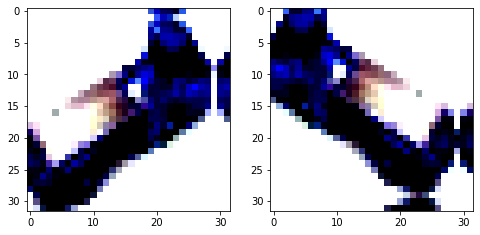

In [ ]:
tmp = unsup_loader.__iter__()  # イテレータを作成
data1, data2 = next(tmp)      # ラベルなしデータのDataloaderから摂動を付与した２つのデータを取得

# データの可視化
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4))

ax1.imshow(data1[0].permute(1,2,0))
ax2.imshow(data2[0].permute(1,2,0))

fig.show()

## ネットワークの定義
畳み込みニューラルネットワークを定義します．\
今回は 11.knowledge_distillation や 12.deep_mutual_learning で使用したネットワークと同様の構造を利用します．

In [ ]:
class CNN(nn.Module):
    def __init__(self, widen_factor=1):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16*widen_factor, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16*widen_factor, 32*widen_factor, kernel_size=3, stride=1, padding=1)
        self.l1 = nn.Linear(8*8*32*widen_factor, 1024*widen_factor)
        self.l2 = nn.Linear(1024*widen_factor, 1024*widen_factor)
        self.l3 = nn.Linear(1024*widen_factor, 10)
        self.act = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        h = self.pool(self.act(self.conv1(x)))
        h = self.pool(self.act(self.conv2(h)))
        h = h.view(h.size()[0], -1)
        h = self.act(self.l1(h))
        h = self.act(self.l2(h))
        h = self.l3(h)
        return h

## 教師あり学習による学習と評価
半教師あり学習の結果と比較するために，ラベルありデータのみを用いた教師あり学習を行います．

### 学習条件の設定

In [ ]:
# 学習回数の設定
NUM_EPOCH = 30

# ネットワークの用意
sup_net = CNN(widen_factor=1).cuda()

# 最適化方法の設定
optimizer = torch.optim.SGD(sup_net.parameters(), lr=0.01, momentum=0.9)

### 学習と評価
ネットワークを教師あり学習します．\
また，５epochごとに評価用データを用いてネットワークの評価を行います．

In [ ]:
start = time()
for epoch in range(1, NUM_EPOCH+1):
    # ネットワークの学習 ----------------------------------------------------------
    # ネットワークを学習モードへ変更
    sup_net.train()

    # ログ用の設定
    sum_loss = 0.0
    count = 0
    
    for image, label in train_loader:
        # 学習用データをGPUへ
        image = image.cuda()
        label = label.cuda()
        
        # 学習用データをネットワークへ入力
        logits = sup_net(image)
        
        # 損失の計算(教師付きデータ)
        loss = F.cross_entropy(logits, label)
        
        # パラメータの更新
        sup_net.zero_grad()
        loss.backward()
        optimizer.step()
        
        # ログ用に損失値と正解したデータ数を取得
        sum_loss += loss.item()
        pred   = torch.argmax(logits, dim=1)
        count += torch.sum(pred == label)
        
    # ログの表示
    print(f"epoch: {epoch},\
            mean loss: {round(sum_loss/len(train_loader), 3)},\
            mean accuracy: {round(count.item()/len(train_loader.dataset), 2)},\
            elapsed_time :{round(time()-start, 2)}")

    # ネットワークの評価 ----------------------------------------------------------
    if (epoch%5 == 0) or (epoch == NUM_EPOCH):  # 5 epoch毎に評価
        # ネットワークを評価モードへ変更
        sup_net.eval()

        # 評価の実行
        count = 0
        with torch.no_grad():
            for image, label in test_loader:
                # 評価用データをGPUへ
                image = image.cuda()
                label = label.cuda()
                
                # 評価用データをネットワークへ入力
                logits = sup_net(image)
                
                # 正解したデータ数を取得
                pred   = torch.argmax(logits, dim=1)
                count += torch.sum(pred == label)

        # 評価結果の表示
        print(f"test accuracy: {count.item()/len(test_loader.dataset)}")

epoch: 1,            mean loss: 2.266,            mean accuracy: 0.15,            elapsed_time :7.4
epoch: 2,            mean loss: 2.047,            mean accuracy: 0.23,            elapsed_time :8.75
epoch: 3,            mean loss: 1.877,            mean accuracy: 0.32,            elapsed_time :10.09
epoch: 4,            mean loss: 1.773,            mean accuracy: 0.36,            elapsed_time :11.42
epoch: 5,            mean loss: 1.662,            mean accuracy: 0.39,            elapsed_time :12.79
test accuracy: 0.3853
epoch: 6,            mean loss: 1.448,            mean accuracy: 0.45,            elapsed_time :18.19
epoch: 7,            mean loss: 1.28,            mean accuracy: 0.55,            elapsed_time :19.53
epoch: 8,            mean loss: 1.05,            mean accuracy: 0.63,            elapsed_time :20.89
epoch: 9,            mean loss: 0.792,            mean accuracy: 0.71,            elapsed_time :22.23
epoch: 10,            mean loss: 0.637,            mean accuracy:

## 半教師あり学習による学習と評価
logits間の2乗誤差をラベルなしデータに対する損失式として半教師あり学習を行います．

### 学習条件の設定
ラベルなしデータに対する損失値に重み付け (w_unlabel) を行うことで，ラベルありデータを用いた学習とラベルなしデータを用いた学習のどちらに重きを置くのかを制御します．\
今回は，重みとして１を使用します．

In [ ]:
# 学習回数の設定
NUM_EPOCH = 30

# 教師なしデータの損失に対する重み付け
w_unlabel = 1.0

# ネットワークの用意
net = CNN(widen_factor=1).cuda()

# 最適化方法の設定
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

### 学習と評価
ネットワークを半教師あり学習します．\
ラベルありデータはfor文，ラベルなしデータはイテレータを作成してデータを取り出します，\
また，５epochごとに評価用データを用いてネットワークの評価を行います．

In [ ]:
start = time()
for epoch in range(1, NUM_EPOCH+1):
    # ネットワークの学習 ----------------------------------------------------------
    # ネットワークを学習モードへ変更
    net.train()

    # ログ用の設定
    sum_loss_sup   = 0.0
    sum_loss_unsup = 0.0
    sum_loss = 0.0
    count = 0
    
    # 教師なし用Dataloaderの設定（イテレータの作成）
    iter_u = iter(unsup_loader)
    
    for img, label in train_loader:  # ラベルありデータの取得
        # ラベルなしデータの取得
        try:
            unlabel_img1, unlabel_img2 = next(iter_u)
        except StopIteration:
            iter_u = iter(unsup_loader)
            unlabel_img1, unlabel_img2 = next(iter_u)

        # 学習用データをGPUへ
        image = torch.cat([img, unlabel_img1, unlabel_img2]).cuda()  # ラベルありデータとラベルなしデータを1つに
        label = label.cuda()
        
        # 学習用データをネットワークへ入力
        logits_all = net(image)
        
        # 損失の計算(ラベルありデータ)
        logits = logits_all[:len(img)]  # ラベルありデータに対する出力を取得
        loss_sup = F.cross_entropy(logits, label)  # ラベルありデータに対する損失を計算 (Cross Entropy loss)

        # 損失の計算(ラベルなしデータ)
        logits_unsup = logits_all[len(img):]  # ラベルなしデータに対する出力を取得
        logits1, logits2 = torch.chunk(logits_unsup, 2)  # 摂動を付与した2サンプルに対する出力を取得

        loss_unsup = F.mse_loss(logits2, logits1)  # ラベルなしデータに対する損失を計算

        # 最終的な損失を計算
        loss = loss_sup + w_unlabel*loss_unsup
        
        # パラメータの更新
        net.zero_grad()
        loss.backward()
        optimizer.step()
        
        # ログ用に損失値と正解したデータ数を取得
        sum_loss += loss.item()               # 損失の合計値
        sum_loss_sup   += loss_sup.item()     # ラベルありデータに対する損失
        sum_loss_unsup += loss_unsup.item()   # ラベルなしデータに対する損失
        
        pred   = torch.argmax(logits, dim=1)  # 値の最も高いクラスの抽出
        count += torch.sum(pred == label)     # 正解したデータの数をカウント
        
    # ログの表示
    print( f"epoch: {epoch},\
             mean loss: {round(sum_loss/len(train_loader), 3)},\
             label loss: {round(sum_loss_sup/len(train_loader), 3)},\
             unlabel loss: {round(w_unlabel*sum_loss_unsup/len(train_loader), 3)},\
             mean accuracy: {round(count.item()/len(train_loader.dataset), 2)},\
             elapsed_time :{round(time()-start, 2)}" )

    # ネットワークの評価 ----------------------------------------------------------
    if (epoch%5 == 0) or (epoch == NUM_EPOCH):  # 5 epoch毎に評価
        # ネットワークを評価モードへ変更
        net.eval()

        # 評価の実行
        count = 0
        with torch.no_grad():
            for image, label in test_loader:
                # 評価用データをGPUへ
                image = image.cuda()
                label = label.cuda()
                
                # 評価用データをネットワークへ入力
                logits = net(image)
                
                # 正解したデータ数を取得
                pred   = torch.argmax(logits, dim=1)
                count += torch.sum(pred == label)

        # 評価結果の表示
        print(f"test accuracy: {count.item()/len(test_loader.dataset)}")

epoch: 1,             mean loss: 2.277,             label loss: 2.275,             unlabel loss: 0.002,             mean accuracy: 0.15,             elapsed_time :41.58
epoch: 2,             mean loss: 2.108,             label loss: 2.08,             unlabel loss: 0.028,             mean accuracy: 0.25,             elapsed_time :81.21
epoch: 3,             mean loss: 2.006,             label loss: 1.963,             unlabel loss: 0.043,             mean accuracy: 0.3,             elapsed_time :120.77
epoch: 4,             mean loss: 1.861,             label loss: 1.797,             unlabel loss: 0.063,             mean accuracy: 0.36,             elapsed_time :160.42
epoch: 5,             mean loss: 1.754,             label loss: 1.671,             unlabel loss: 0.083,             mean accuracy: 0.4,             elapsed_time :202.5
test accuracy: 0.3889
epoch: 6,             mean loss: 1.674,             label loss: 1.562,             unlabel loss: 0.113,             mean accuracy: 0.4

# 課題
1. ラベルなしデータに対する損失設計を変更してみましょう
2. ラベルありデータとラベルなしデータの比率を変更してみましょう

#### ラベルなしデータに対する損失設計の例

In [ ]:
# 確率分布に対するKL-divergence
def kl_divergence(logits_1, logits_2):
    softmax_1 = F.softmax(logits_1, dim=1)
    softmax_2 = F.softmax(logits_2, dim=1)
    kl = (softmax_2 * torch.log((softmax_2 / (softmax_1+1e-10)) + 1e-10)).sum(dim=1)
    return kl.mean()

loss_unsup = (kl_divergence(logits1, logits2)+kl_divergence(logits2, logits1))/2  # KL-divergenceは距離の公理を満たさない指標のため双方向の平均を計算

In [ ]:
# 確率分布に対する平均2乗誤差
loss_unsup = F.mse_loss(F.softmax(logits2, dim=1), F.softmax(logits1, dim=1))